# Problem #1

## Data Ingest and Formatting

In [2]:
# Common Imports
import csv
import pathlib
import statistics
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from scipy.stats import norm, halfnorm
from scipy.optimize import differential_evolution
from filterpy.kalman import ExtendedKalmanFilter

# Ensure the plot output directory exists
pathlib.Path('./out').mkdir(parents=True, exist_ok=True)

# Read in the training data, training labels, and test data
training_data = pd.read_csv('./data/ekf_training_data.csv', sep=",", skipinitialspace=True)
training_labels = pd.read_csv('./data/ekf_training_labels.csv', sep=",", skipinitialspace=True)
test_data = pd.read_csv('./data/ekf_test_data.csv', sep=",", skipinitialspace=True)

# Rename Columns for code convenience
training_data.columns = ['Time', 'dist_0', 'angle_0', 'size_0',
                                 'dist_1', 'angle_1', 'size_1',
                                 'dist_2', 'angle_2', 'size_2',
                                 'dist_3', 'angle_3', 'size_3']
training_labels.columns = ['Time', 'x_0', 'y_0', 's_0',
                                   'x_1', 'y_1', 's_1',
                                   'x_2', 'y_2', 's_2',
                                   'x_3', 'y_3', 's_3']
test_data.columns = ['Time', 'dist_0', 'angle_0', 'size_0',
                             'dist_1', 'angle_1', 'size_1',
                             'dist_2', 'angle_2', 'size_2']

# Combine the training data and labels into one dataset
training_combined = training_data.merge(training_labels, on='Time', how='outer')

# Output the list of columns for each dataset
print("Training Data Columns: ", list(training_data.columns))
print("Training Labels Columns: ", list(training_labels.columns))
print("Training Combined Columns: ", list(training_combined.columns))
print("Test Data Columns: ", list(test_data.columns))

Training Data Columns:  ['Time', 'dist_0', 'angle_0', 'size_0', 'dist_1', 'angle_1', 'size_1', 'dist_2', 'angle_2', 'size_2', 'dist_3', 'angle_3', 'size_3']
Training Labels Columns:  ['Time', 'x_0', 'y_0', 's_0', 'x_1', 'y_1', 's_1', 'x_2', 'y_2', 's_2', 'x_3', 'y_3', 's_3']
Training Combined Columns:  ['Time', 'dist_0', 'angle_0', 'size_0', 'dist_1', 'angle_1', 'size_1', 'dist_2', 'angle_2', 'size_2', 'dist_3', 'angle_3', 'size_3', 'x_0', 'y_0', 's_0', 'x_1', 'y_1', 's_1', 'x_2', 'y_2', 's_2', 'x_3', 'y_3', 's_3']
Test Data Columns:  ['Time', 'dist_0', 'angle_0', 'size_0', 'dist_1', 'angle_1', 'size_1', 'dist_2', 'angle_2', 'size_2']


## Sensor Variance

### Size Measurement Variance

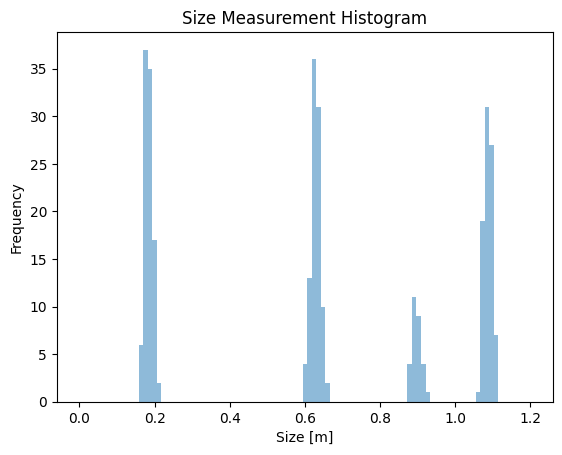

In [3]:
# Plot a histogram of all the size measurements
measurements = pd.concat([
    training_data.iloc[:,3],
    training_data.iloc[:,6],
    training_data.iloc[:,9],
    training_data.iloc[:,12]
])
plt.figure()
bins = np.linspace(0, 1.2, 100)
plt.hist(measurements, bins=bins, alpha=0.5, label='Fish 0')
plt.title('Size Measurement Histogram')
plt.xlabel('Size [m]')
plt.ylabel('Frequency')
plt.savefig('out/p1_size_hist.png')
plt.show()

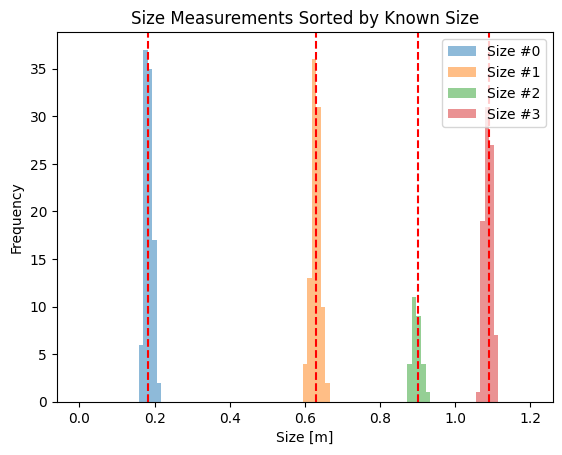

In [4]:
# Group size measurement with closest known size
known_sizes = [
    training_labels.loc[pd.notnull(training_labels['s_0']), 's_0'].values[0],
    training_labels.loc[pd.notnull(training_labels['s_1']), 's_1'].values[0],
    training_labels.loc[pd.notnull(training_labels['s_2']), 's_2'].values[0],
    training_labels.loc[pd.notnull(training_labels['s_3']), 's_3'].values[0],
]
sorted_measurements = {}
for size in known_sizes:
    sorted_measurements[size] = []
for measurement in measurements:
    if np.isnan(measurement):
        continue
    closest_size = min(known_sizes, key=lambda x:abs(x-measurement))
    sorted_measurements[closest_size].append(measurement)

# Plot the grouped size measurements
plt.figure()
bins = np.linspace(0, 1.2, 100)
for i, size in enumerate(known_sizes):
    plt.hist(sorted_measurements[size], bins=bins, alpha=0.5, label=f'Size #{i}')
    plt.axvline(x=size, color='r', linestyle='--')
plt.title('Size Measurements Sorted by Known Size')
plt.xlabel('Size [m]')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('out/p1_sorted_size_hist.png')
plt.show()


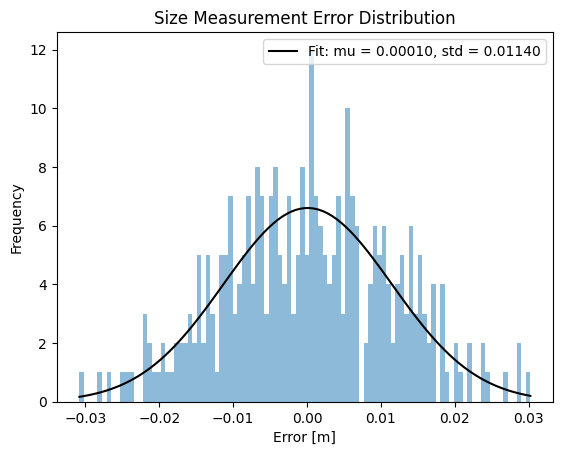

Size Measurement Variance: 0.0001298833306604814


In [5]:
# Calculate the variance of the size measurement
errors = []
for size in known_sizes:
    for measurement in sorted_measurements[size]:
        errors.append(measurement - size)

# Plot the error distribution
plt.figure()
hist, bins, _ = plt.hist(errors, bins=100, alpha=0.5)
xmin, xmax = plt.xlim()
mu, std = norm.fit(errors)
p = norm.pdf(bins, mu, std)
plt.plot(bins, p/p.sum() * len(errors), 'k', label="Fit: mu = %.5f, std = %.5f" % (mu, std))
plt.title('Size Measurement Error Distribution')
plt.xlabel('Error [m]')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('out/p1_size_error_hist.png')
plt.show()

# Calculate the variance of the size measurement
size_variance = np.var(errors)
print(f"Size Measurement Variance: {size_variance}")

### Position Measurement Variances

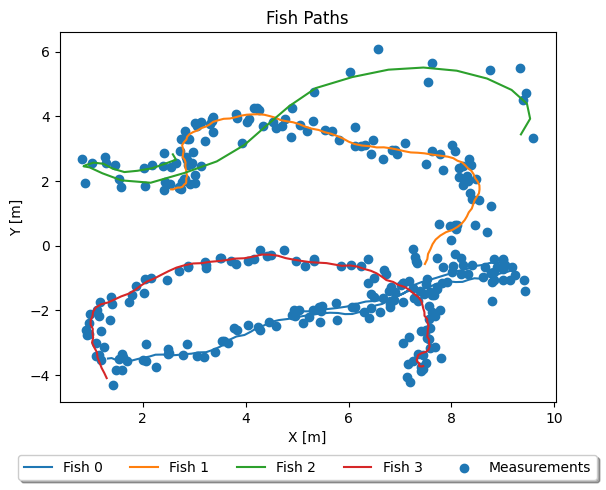

In [6]:
# Combine all the position measurements into one dataset
positions = pd.DataFrame({
    'r': pd.concat([
        training_data.iloc[:,1],
        training_data.iloc[:,4],
        training_data.iloc[:,7],
        training_data.iloc[:,10]
    ]),
    't': pd.concat([
        training_data.iloc[:,2],
        training_data.iloc[:,5],
        training_data.iloc[:,8],
        training_data.iloc[:,11]
    ]),
    'time': pd.concat([
        training_data['Time'],
        training_data['Time'],
        training_data['Time'],
        training_data['Time']
    ])
})
positions = positions.dropna().reset_index(drop=True)
positions['x'] = positions['r'] * np.cos(np.deg2rad(positions['t']))
positions['y'] = positions['r'] * np.sin(np.deg2rad(positions['t']))

# Plot the known paths of the fish and scatter the measurements over them
plt.figure()
plt.plot(training_labels['x_0'], training_labels['y_0'], label='Fish 0')
plt.plot(training_labels['x_1'], training_labels['y_1'], label='Fish 1')
plt.plot(training_labels['x_2'], training_labels['y_2'], label='Fish 2')
plt.plot(training_labels['x_3'], training_labels['y_3'], label='Fish 3')
plt.scatter(positions['x'], positions['y'], label='Measurements')
plt.title('Fish Paths')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),
           fancybox=True, shadow=True, ncol=5)
plt.savefig('out/p1_pos_plot.png', bbox_inches='tight')
plt.show()


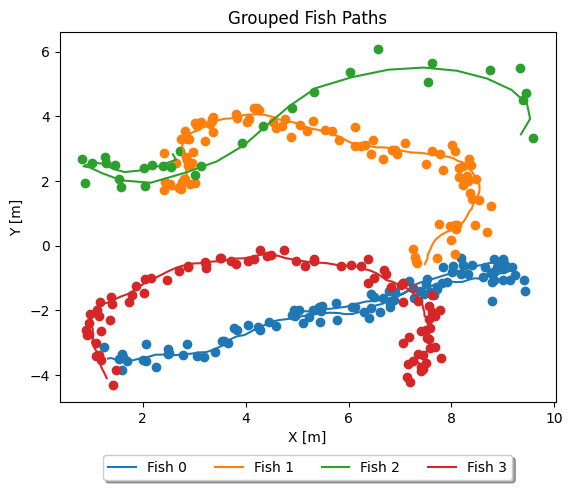

In [7]:
# Try grouping position readings by nearest known fish position
grouped_positions = {}
for i in range(4):
    grouped_positions[i] = []
for index, row in positions.iterrows():
    time = row['time']
    distances = [
        np.linalg.norm([row['x'] - training_labels.loc[training_labels['Time']==time, f'x_{i}'],
                        row['y'] - training_labels.loc[training_labels['Time']==time, f'y_{i}']])
        for i in range(4)
    ]
    distances = [d if not np.isnan(d) else np.inf for d in distances]
    closest_fish = np.argmin(distances, )
    grouped_positions[closest_fish].append(row)
    
# Plot the grouped position readings
plt.figure()
for i in range(4):
    fish_positions = pd.DataFrame(grouped_positions[i])
    plt.scatter(fish_positions['x'], fish_positions['y'], color=f'C{i}')
    plt.plot(training_labels[f'x_{i}'], training_labels[f'y_{i}'], label=f'Fish {i}', color=f'C{i}')
plt.title('Grouped Fish Paths')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),
           fancybox=True, shadow=True, ncol=5)
plt.savefig('out/p1_sorted_pos_plot.png', bbox_inches='tight')
plt.show()

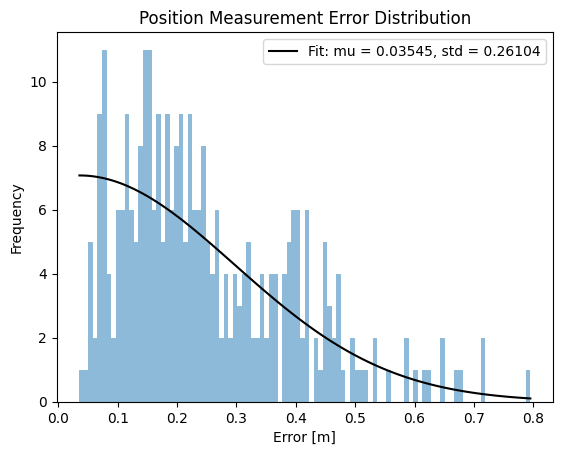

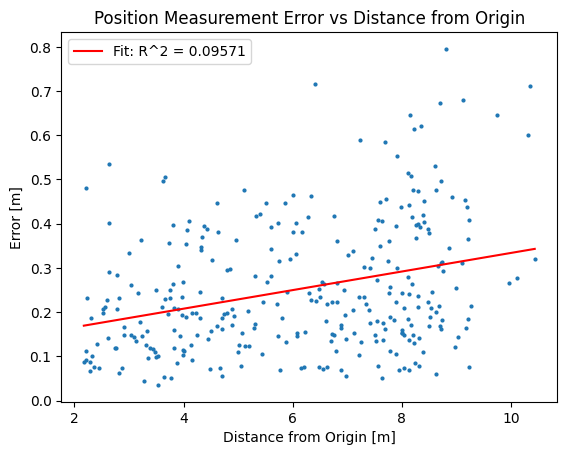

In [8]:
# Calculate the variance of the position measurements
errors = []
for i in range(4):
    for position in grouped_positions[i]:
        time = position['time']
        x = position['x']
        y = position['y']
        known_x = training_labels.loc[training_labels['Time']==time, f'x_{i}'].values[0]
        known_y = training_labels.loc[training_labels['Time']==time, f'y_{i}'].values[0]
        errors.append(np.linalg.norm([x-known_x, y-known_y]))

# Plot the error distribution
plt.figure()
hist, bins, _ = plt.hist(errors, bins=100, alpha=0.5)
xmin, xmax = plt.xlim()
mu, std = halfnorm.fit(errors)
p = halfnorm.pdf(bins, mu, std)
plt.plot(bins, p/p.sum() * len(errors), 'k', label="Fit: mu = %.5f, std = %.5f" % (mu, std))
plt.title('Position Measurement Error Distribution')
plt.xlabel('Error [m]')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('out/p1_pos_error_hist.png')
plt.show()

# Plot scatter of Abs error vs distance from (0, 0)
errors = []
for i in range(4):
    for position in grouped_positions[i]:
        time = position['time']
        x = position['x']
        y = position['y']
        known_x = training_labels.loc[training_labels['Time']==time, f'x_{i}'].values[0]
        known_y = training_labels.loc[training_labels['Time']==time, f'y_{i}'].values[0]
        errors.append((np.linalg.norm([known_x, known_y]),np.linalg.norm([x-known_x, y-known_y])))
        
errors = np.array(errors)
plt.figure()
plt.scatter(errors[:,0], errors[:,1], s=4)
m, b, r, _, _ = stats.linregress(errors[:,0], errors[:,1])
x_axis = np.linspace(np.min(errors[:,0]), np.max(errors[:,0]), 100)
plt.plot(x_axis, m*x_axis + b, color='r', label=f'Fit: R^2 = {r**2:.5f}')
plt.title('Position Measurement Error vs Distance from Origin')
plt.xlabel('Distance from Origin [m]')
plt.ylabel('Error [m]')
plt.legend()
plt.savefig('out/p1_pos_error_dist_correlation.png')
plt.show()

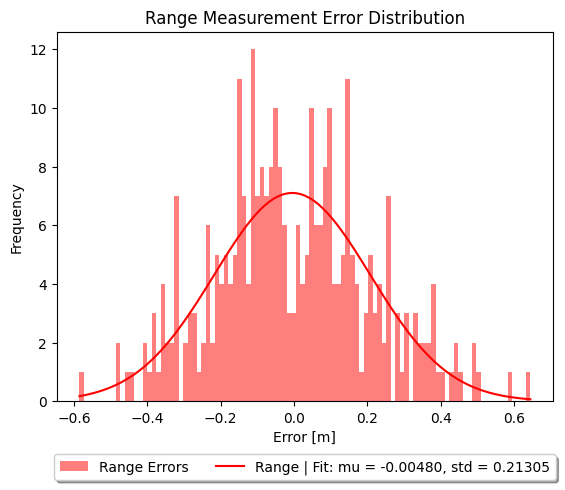

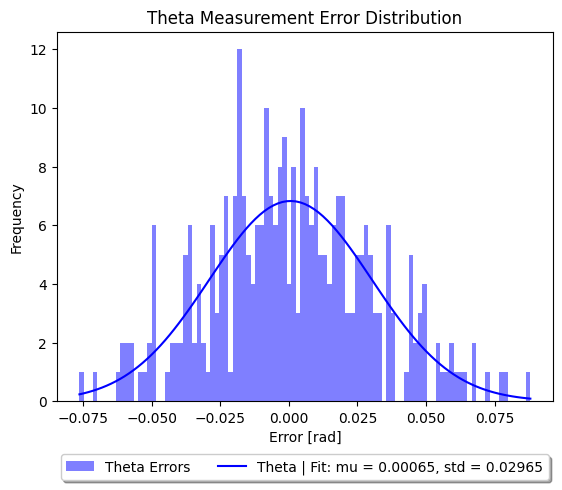

Range Measurement Variance: 0.04539078586229167
Theta Measurement Variance: 0.0008788995081357296


In [9]:
# Calculate the variance of the r and t measurements
errors = []
for i in range(4):
    for position in grouped_positions[i]:
        time = position['time']
        r = position['r']
        t = np.deg2rad(position['t'])
        known_x = training_labels.loc[training_labels['Time']==time, f'x_{i}'].values[0]
        known_y = training_labels.loc[training_labels['Time']==time, f'y_{i}'].values[0]
        known_r = np.linalg.norm([known_x, known_y])
        known_t = np.arctan2(known_y, known_x)
        errors.append((known_r - r, known_t - t))
errors = np.array(errors)

# Plot the r error distribution
plt.figure()
hist, bins, _ = plt.hist(errors[:,0], bins=100, alpha=0.5, label='Range Errors', color='r')
xmin, xmax = plt.xlim()
mu, std = norm.fit(errors[:,0])
p = norm.pdf(bins, mu, std)
plt.plot(bins, p/p.sum() * len(errors[:,0]), label="Range | Fit: mu = %.5f, std = %.5f" % (mu, std), color='r')
plt.title('Range Measurement Error Distribution')
plt.xlabel('Error [m]')
plt.ylabel('Frequency')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),
           fancybox=True, shadow=True, ncol=2)
plt.savefig('out/p1_r_pos_error_hist.png', bbox_inches='tight')
plt.show()

# Plot the t error distributions
plt.figure()
hist, bins, _ = plt.hist(errors[:,1], bins=100, alpha=0.5, label='Theta Errors', color='b')
xmin, xmax = plt.xlim()
mu, std = norm.fit(errors[:,1])
p = norm.pdf(bins, mu, std)
plt.plot(bins, p/p.sum() * len(errors[:,1]), label="Theta | Fit: mu = %.5f, std = %.5f" % (mu, std), color='b')
plt.title('Theta Measurement Error Distribution')
plt.xlabel('Error [rad]')
plt.ylabel('Frequency')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),
           fancybox=True, shadow=True, ncol=2)
plt.savefig('out/p1_t_pos_error_hist.png', bbox_inches='tight')
plt.show()

# Calculate the variances
range_variance = np.var(errors[:,0])
theta_variance = np.var(errors[:,1])
print(f"Range Measurement Variance: {range_variance}")
print(f"Theta Measurement Variance: {theta_variance}")

## Extended Kalman Filter for Single Fish Tracking
#### State Matrix:
$$
\text{State Matrix} \, = 
\begin{bmatrix}
    \text{position} \\
    \text{velocity} \\
    \text{acceleration} \\
    \text{size} \\
\end{bmatrix}
=
\begin{bmatrix}
    x,y \\
    \dot{x}, \dot{y} \\
    \ddot{x}, \ddot{y} \\
    s, 0 \\
\end{bmatrix}
$$

#### State update equations:
$$
x = F x
\\~\\
\begin{aligned}
    \text{Derivative Matrix} \, &=
    \begin{bmatrix}
        \text{velocity} \\
        \text{acceleration} \\
        \text{jerk} \\
        \text{growth} \\
    \end{bmatrix} \\
    &=
    \begin{bmatrix}
        (\dot{x}, \dot{y}) + w_\text{vel}\\
        (\ddot{x}, \ddot{y}) + w_\text{acc}\\
        \left(\stackrel{\dotsm}{x}, \stackrel{\dotsm}{y} \right) + w_\text{jerk}\\
        (\dot{s} + w_\text{size}, 0)
    \end{bmatrix} \\
    &=
    \begin{bmatrix}
        (\dot{x}, \dot{y}) + w_\text{vel}\\
        (\ddot{x}, \ddot{y}) + w_\text{acc}\\
        (0, 0) + w_\text{jerk}\\
        (0 + w_\text{size}, 0)
    \end{bmatrix} \\
    &=
    \begin{bmatrix}
        0 & 1 & 0 & 0\\
        0 & 0 & 1 & 0\\
        0 & 0 & 0 & 0\\
        0 & 0 & 0 & 0\\
    \end{bmatrix}
    \begin{bmatrix}
        (x,y) \\
        (\dot{x}, \dot{y}) \\
        (\ddot{x}, \ddot{y}) \\
        (s, 0) \\
    \end{bmatrix}
    +
    \begin{bmatrix}
        w_\text{vel} \\
        w_\text{acc} \\
        w_\text{jerk} \\
        w_\text{size} \\
    \end{bmatrix}
\end{aligned}
\\~\\
F = \frac{\partial f(S)}{\partial S} \approx 
\begin{bmatrix}
    0 & 1 & 0 & 0\\
    0 & 0 & 1 & 0\\
    0 & 0 & 0 & 0\\
    0 & 0 & 0 & 0\\
\end{bmatrix}
\begin{bmatrix}
    (x,y) \\
    (\dot{x}, \dot{y}) \\
    (\ddot{x}, \ddot{y}) \\
    (s, 0) \\
\end{bmatrix}
+
\begin{bmatrix}
    w_\text{vel} \\
    w_\text{acc} \\
    w_\text{jerk} \\
    w_\text{size} \\
\end{bmatrix}
\\~\\
\Phi = I + F \Delta t + \frac{(F \Delta t)^2}{2!} + \frac{(F \Delta t)^3}{3!} + \dots \\
\Phi \approx I + F \Delta t
\\~\\
S_k = \Phi(\Delta t) S_{k-1}
$$

#### Measurement Matrix:
$$
\text{Measurements} \, =
\begin{bmatrix}
    \text{range} \\
    \text{angle} \\
    \text{size} \\
\end{bmatrix}
$$

##### Range Measurement:
$$
\text{Range}\, = r = ||\text{pos}|| = \sqrt{x^2 + y^2}
\\~\\
R = \left.\frac{\partial r}{\partial S} \right|_{S}
\\~\\
R = 
\begin{bmatrix}
    \left(
        \frac{x}{\sqrt{x^2 + y^2}},
        \frac{y}{\sqrt{x^2 + y^2}}
    \right) \\
    0, 0 \\
    0, 0 \\
    0, 0 \\
\end{bmatrix}
$$

##### Angle Measurement:
$$
\text{Angle}\, = \theta = \tan^{-1}\left(\frac{y}{x}\right) 
\\~\\
\Theta = \left.\frac{\partial \theta}{\partial S} \right|_{S}
\\~\\
\Theta =
\begin{bmatrix}
    \left(
        \frac{-y}{x^2 + y^2},
        \frac{x}{x^2 + y^2}
    \right) \\
    0, 0 \\
    0, 0 \\
    0, 0 \\
\end{bmatrix}
$$

##### Size Measurement:
$$
\text{Size}\, = s
\\~\\
S_\text{ize} = \left.\frac{\partial s}{\partial S} \right|_{S}
\\~\\
S_\text{ize} =
\begin{bmatrix}
    0, 0 \\
    0, 0 \\
    0, 0 \\
    0, 0 \\
\end{bmatrix}
$$


In [10]:

class FishExtendedKalmanFilter:
    def __init__(self, range, theta, size, pos_noise, vel_noise, acc_noise, size_noise):
        x, y = (range * np.cos(np.deg2rad(theta)),
                range * np.sin(np.deg2rad(theta)))
        self.dt = 0.1 # Seconds
        self.ekf = ExtendedKalmanFilter(dim_x=7, dim_z=3) # 4 states with 3 measurements
        self.ekf.x = np.array([x, y, 0, 0, 0, 0, size]) # Initial position and size
        self.ekf.F = np.eye(7) + np.array([[0, 0, self.dt, 0, 0.5 * self.dt**2, 0, 0], # State transition matrix
                                           [0, 0, 0, self.dt, 0, 0.5 * self.dt**2, 0],
                                           [0, 0, 0, 0, self.dt, 0, 0],
                                           [0, 0, 0, 0, 0, self.dt, 0],
                                           [0, 0, 0, 0, 0, 0, 0],
                                           [0, 0, 0, 0, 0, 0, 0],
                                           [0, 0, 0, 0, 0, 0, 0]])
        self.ekf.R = np.diag([range_variance, # Experimental measurement noise
                              theta_variance,
                              size_variance])
        self.ekf.Q = np.diag([pos_noise, # Process noise
                              pos_noise,
                              vel_noise,
                              vel_noise,
                              acc_noise,
                              acc_noise,
                              size_noise])
        
    # Expected range reading for State
    def _range_at(self, S):
        return np.linalg.norm(S[0:2])
    # Expected range rate for State
    def _range_J_at(self, S):
        return np.array([
            S[0] / np.linalg.norm(S[0:2]),
            S[1] / np.linalg.norm(S[0:2]),
            0,
            0,
            0,
            0,
            0,
        ])
    # Expected theta reading for State
    def _theta_at(self, S):
        return np.arctan2(S[1], S[0])
    # Expected theta rate for State
    def _theta_J_at(self, S):
        return np.array([
            -S[1] / (S[0]**2 + S[1]**2),
            S[0] / (S[0]**2 + S[1]**2),
            0,
            0,
            0,
            0,
            0,
        ])
    # Expected size reading for State
    def _size_at(self, S):
        return S[6]
    # Expected size rate for State
    def _size_J_at(self, S):
        return np.array([
            0,
            0,
            0,
            0,
            0,
            0,
            1,
        ])
    
        # Expected sensor readings for State
    def _H_at(self, S):
        return np.array([self._range_at(S),
                         self._theta_at(S),
                         self._size_at(S)])
    # Expected sensor rates for State
    def _H_J_at(self, S):
        return np.array([self._range_J_at(S),
                         self._theta_J_at(S),
                         self._size_J_at(S)])
        
    def update(self, range, theta, size):
        self.ekf.update(np.array([range, np.deg2rad(theta), size]), self._H_J_at, self._H_at)
    
    def predict(self):
        self.ekf.predict()
        
    def update_predict(self, range, theta, size):
        self.update(range, theta, size)
        self.predict()
    
    def covariance(self):
        return self.ekf.P
        
    def current_state(self):
        return self.ekf.x
    
    def predicted_next_state(self):
        return self.ekf.x @ self.ekf.F
    
    # Z-score of a measurement against the predicted measurement
    def z_score_of_measurement_match(self, range, theta, size, max_size_z_score):
        # Get expected sensor readings
        next = self.predicted_next_state()
        r_next = self._range_at(next)
        t_next = self._theta_at(next)
        s_next = self._size_at(next)
        
        # Calculate the likelihood of the measurement
        r_z_scr = np.abs((range - r_next) / range_variance**0.5)
        t_z_scr = np.abs((np.deg2rad(theta) - t_next) / theta_variance**0.5)
        s_z_scr = np.abs((size - s_next) / size_variance**0.5)
        # Return the position z score, or inf if the size z-score is too high
        if s_z_scr > max_size_z_score:
            return np.inf
        else:
            return r_z_scr + t_z_scr
    
    # RMS error of the predicted path vs the actual path
    def score_pos_accuracy(self, ranges, thetas, sizes, x, y):
        # Run an entire measurement set through the filter
        predicted = []
        for r, t, s in zip(ranges, thetas, sizes):
            self.update(r, t, s)
            self.predict()
            predicted.append(self.current_state())
        predicted = np.array(predicted)
        
        # Calculate the rms error from the actual path
        x = np.array(x)
        y = np.array(y)
        error = np.sqrt(np.mean((x - predicted[:,0])**2 + (y - predicted[:,1])**2))
        return error
    
    # RMS error of the predicted size vs the actual size
    def score_size_accuracy(self, ranges, thetas, sizes, actual_sizes):
        # Run an entire measurement set through the filter
        predicted = []
        for r, t, s in zip(ranges, thetas, sizes):
            self.update(r, t, s)
            self.predict()
            predicted.append(self.current_state())
        predicted = np.array(predicted)
        
        # Calculate the rms error from the actual path
        actual_sizes = np.array(actual_sizes)
        error = np.sqrt(np.mean((actual_sizes - predicted[:,6])**2))
        return error

In [11]:
# Optimize the Process Noise Values
print("Optimizing Process Noise Values on Fish 0...")
fish_0_test = training_combined[["Time", 'x_0', 'y_0', 's_0']]
fish_0_test = fish_0_test.assign(
    real_dist_0 = np.array([np.linalg.norm([x, y]) for x, y in zip(fish_0_test['x_0'], fish_0_test['y_0'])]),
    real_angle_0 = np.rad2deg(np.arctan2(fish_0_test['y_0'], fish_0_test['x_0'])),
    real_size_0 = fish_0_test['s_0'],
)
fish_0_test = fish_0_test.assign(
    sim_dist_0 = fish_0_test['real_dist_0'] + np.random.normal(0, range_variance**0.5, len(fish_0_test)),
    sim_angle_0 = fish_0_test['real_angle_0'] + np.random.normal(0, theta_variance**0.5, len(fish_0_test)),
    sim_size_0 = fish_0_test['real_size_0'] + np.random.normal(0, size_variance**0.5, len(fish_0_test)),
)
def pos_0_cost_function(x):
    sys = FishExtendedKalmanFilter(fish_0_test['sim_dist_0'][0],
                                   fish_0_test['sim_angle_0'][0],
                                   fish_0_test['sim_size_0'][0],
                                   *x)
    return sys.score_pos_accuracy(fish_0_test['sim_dist_0'],
                                  fish_0_test['sim_angle_0'],
                                  fish_0_test['sim_size_0'],
                                  training_labels['x_0'],
                                  training_labels['y_0'])
def size_0_cost_function(x):
    sys = FishExtendedKalmanFilter(fish_0_test['sim_dist_0'][0],
                                   fish_0_test['sim_angle_0'][0],
                                   fish_0_test['sim_size_0'][0],
                                   *x)
    return sys.score_size_accuracy(fish_0_test['sim_dist_0'],
                                   fish_0_test['sim_angle_0'],
                                   fish_0_test['sim_size_0'],
                                   training_labels['s_0'])
result_pos_0 = differential_evolution(pos_0_cost_function,
                                      [(0, 1), (0, 1), (0, 1), (0, 1)],
                                      maxiter=10000)
result_size_0 = differential_evolution(size_0_cost_function,
                                       [(0, 1), (0, 1), (0, 1), (0, 1)],
                                       maxiter=10000)
print(f"Optimized Process Noise Values on Fish 0: [{result_pos_0.x[0]},{result_pos_0.x[1]},{result_pos_0.x[2]},{result_size_0.x[3]}]")

print("Optimizing Process Noise Values on Fish 1...")
fish_1_test = training_combined[["Time", 'x_1', 'y_1', 's_1']]
fish_1_test = fish_1_test.assign(
    real_dist_1 = np.array([np.linalg.norm([x, y]) for x, y in zip(fish_1_test['x_1'], fish_1_test['y_1'])]),
    real_angle_1 = np.rad2deg(np.arctan2(fish_1_test['y_1'], fish_1_test['x_1'])),
    real_size_1 = fish_1_test['s_1'],
)
fish_1_test = fish_1_test.assign(
    sim_dist_1 = fish_1_test['real_dist_1'] + np.random.normal(0, range_variance**0.5, len(fish_1_test)),
    sim_angle_1 = fish_1_test['real_angle_1'] + np.random.normal(0, theta_variance**0.5, len(fish_1_test)),
    sim_size_1 = fish_1_test['real_size_1'] + np.random.normal(0, size_variance**0.5, len(fish_1_test)),
)
def pos_0_cost_function(x):
    sys = FishExtendedKalmanFilter(fish_1_test['sim_dist_1'][0],
                                   fish_1_test['sim_angle_1'][0],
                                   fish_1_test['sim_size_1'][0],
                                   *x)
    return sys.score_pos_accuracy(fish_1_test['sim_dist_1'],
                                  fish_1_test['sim_angle_1'],
                                  fish_1_test['sim_size_1'],
                                  training_labels['x_1'],
                                  training_labels['y_1'])
def size_0_cost_function(x):
    sys = FishExtendedKalmanFilter(fish_1_test['sim_dist_1'][0],
                                   fish_1_test['sim_angle_1'][0],
                                   fish_1_test['sim_size_1'][0],
                                   *x)
    return sys.score_size_accuracy(fish_1_test['sim_dist_1'],
                                   fish_1_test['sim_angle_1'],
                                   fish_1_test['sim_size_1'],
                                   training_labels['s_1'])
result_pos_1 = differential_evolution(pos_0_cost_function,
                                      [(0, 1), (0, 1), (0, 1), (0, 1)],
                                      maxiter=10000)
result_size_1 = differential_evolution(size_0_cost_function,
                                       [(0, 1), (0, 1), (0, 1), (0, 1)],
                                       maxiter=10000)
print(f"Optimized Process Noise Values on Fish 1: [{result_pos_1.x[0]}, {result_pos_1.x[1]}, {result_pos_1.x[2]}, {result_size_1.x[3]}]")

# Average for Fish 0 and Fish 1
x = [(result_pos_0.x[0] + result_pos_1.x[0]) / 2,
     (result_pos_0.x[1] + result_pos_1.x[1]) / 2,
     (result_pos_0.x[2] + result_pos_1.x[2]) / 2,
     (result_size_0.x[3] + result_size_1.x[3]) / 2]
print(f"Average Optimized Process Noise Values: [{x[0]}, {x[1]}, {x[2]}, {x[3]}]")
pos_noise, vel_noise, acc_noise, size_noise = x

Optimizing Process Noise Values on Fish 0...
Optimized Process Noise Values on Fish 0: [0.012136131753758944,0.01871240157437519,0.0,0.0]
Optimizing Process Noise Values on Fish 1...
Optimized Process Noise Values on Fish 1: [0.0, 0.04579975857313133, 0.0, 0.0]
Average Optimized Process Noise Values: [0.006068065876879472, 0.03225608007375326, 0.0, 0.0]


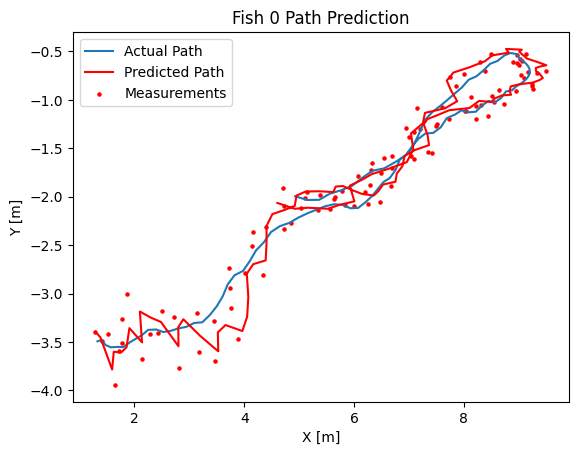

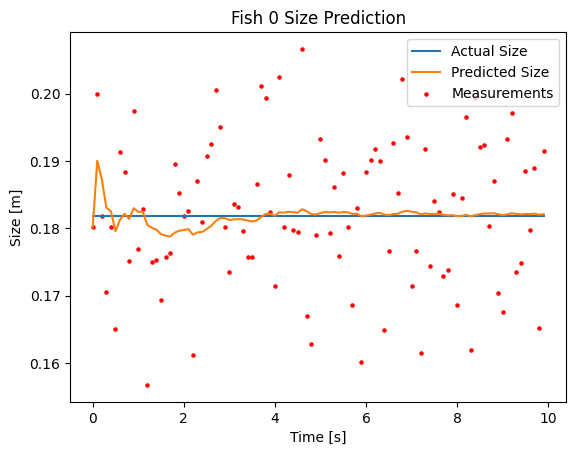

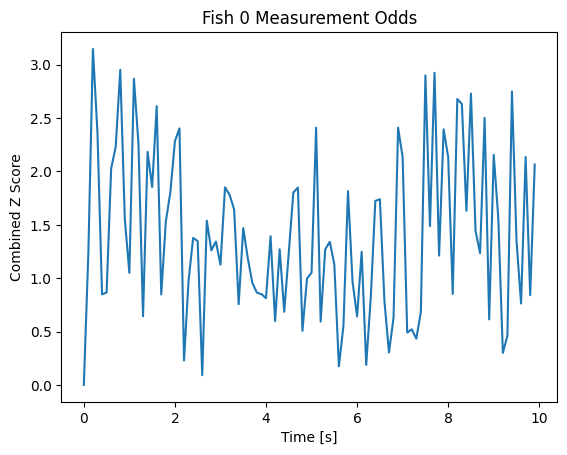

In [12]:
# Test the EKF against a sample dataset of 1 fish
fish_test = training_combined[["Time", "dist_0", 'angle_0', 'size_0', 'x_0', 'y_0', 's_0']]
fish_test = fish_test.assign(
    real_dist_0 = np.array([np.linalg.norm([x, y]) for x, y in zip(fish_test['x_0'], fish_test['y_0'])]),
    real_angle_0 = np.rad2deg(np.arctan2(fish_test['y_0'], fish_test['x_0'])),
    real_size_0 = fish_test['s_0'],
)
fish_test = fish_test.assign(
    sim_dist_0 = fish_test['real_dist_0'] + np.random.normal(0, range_variance**0.5, len(fish_test)),
    sim_angle_0 = fish_test['real_angle_0'] + np.random.normal(0, theta_variance**0.5, len(fish_test)),
    sim_size_0 = fish_test['real_size_0'] + np.random.normal(0, size_variance**0.5, len(fish_test)),
)
sys = FishExtendedKalmanFilter(fish_test["sim_dist_0"][0],
                                fish_test["sim_angle_0"][0],
                                fish_test["sim_size_0"][0],
                                pos_noise, vel_noise, acc_noise, size_noise)

predicted = []
odds = []
for index, meas in fish_test.iterrows():
    odds.append(sys.z_score_of_measurement_match(meas["sim_dist_0"], meas["sim_angle_0"], meas["sim_size_0"], 5))
    sys.update(meas["sim_dist_0"], meas["sim_angle_0"], meas["sim_size_0"])
    sys.predict()
    state = sys.current_state()
    predicted.append(state)
predicted = np.array(predicted)
fish_test = fish_test.assign(px_0=predicted[:,0],
                             py_0=predicted[:,1],
                             ps_0=predicted[:,6])

# Calculate the measured location
fish_test['mx_0'] = fish_test['sim_dist_0'] * np.cos(np.deg2rad(fish_test['sim_angle_0']))
fish_test['my_0'] = fish_test['sim_dist_0'] * np.sin(np.deg2rad(fish_test['sim_angle_0']))

# Plot the predicted vs actual paths
plt.figure()
plt.plot(fish_test['x_0'], fish_test['y_0'], label='Actual Path')
plt.plot(fish_test['px_0'], fish_test['py_0'], label='Predicted Path', color='r')
plt.scatter(fish_test['mx_0'], fish_test['my_0'], label='Measurements', s=5, color='r')
plt.title('Fish 0 Path Prediction')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.legend()
plt.savefig('out/p1_test_fish_0_path.png')
plt.show()

# Plot the size prediction
plt.figure()
plt.plot(fish_test['Time'], fish_test['real_size_0'], label='Actual Size')
plt.plot(fish_test['Time'], fish_test['ps_0'], label='Predicted Size')
plt.scatter(fish_test['Time'], fish_test['sim_size_0'], label='Measurements', s=5, color='r')
plt.title('Fish 0 Size Prediction')
plt.xlabel('Time [s]')
plt.ylabel('Size [m]')
plt.legend()
plt.savefig('out/p1_test_fish_0_size.png')

# Plot the odds of the measurements
plt.figure()
plt.plot(fish_test['Time'], odds)
plt.title('Fish 0 Measurement Odds')
plt.xlabel('Time [s]')
plt.ylabel('Combined Z Score')
plt.savefig('out/p1_test_fish_0_odds.png')
plt.show()


## Multi-Fish Tracking
Create an objct that can track multiple fish using the necessary number of extended Kalman filters.

In [13]:
class MultiTracker:
    def __init__(self, noises, max_pos_z_score=15):
        self.max_size_z_score = 10
        self.max_pos_z_score = max_pos_z_score
        self.max_missed = 5
        self.min_measures = 10
        self.fish_id = 0
        self.trackers = []
        self.errors = []
        self.predictions = {}
        self.pos_noise = noises[0]
        self.vel_noise = noises[1]
        self.acc_noise = noises[2]
        self.size_noise = noises[3]
    
    def add_tracker(self, measurement, time):
        self.trackers.append({
            "id": self.fish_id,
            "ekf": FishExtendedKalmanFilter(measurement[0],
                                            measurement[1],
                                            measurement[2],
                                            self.pos_noise,
                                            self.vel_noise,
                                            self.acc_noise,
                                            self.size_noise),
            "missed": 0,
            "measurements": 1,
            "updated": True
        })
        self.predictions[self.fish_id] = []
        self.fish_id += 1

    def update(self, time, measurements):            
        # Edge-case of no existing trackers
        if len(self.trackers) == 0:
            for measurement in measurements:
                self.add_tracker(measurement, time)
        # Apply measurements to existing trackers, add trackers for unmatched measurements
        else:
            # Create an array of Z-scores for each measurement and tracker combo
            z_scores = np.zeros((len(measurements), len(self.trackers)))
            for i, measurement in enumerate(measurements):
                for j, tracker in enumerate(self.trackers):
                    z_scores[i,j] = tracker["ekf"].z_score_of_measurement_match(measurement[0],
                                                                                measurement[1],
                                                                                measurement[2],
                                                                                self.max_size_z_score)
            # print(z_scores)
            # Try to match measurements to the existing trackers
            for i in range(len(self.trackers)):
                # Ignore matches with too high of a Z-score
                if np.min(z_scores) > self.max_pos_z_score:
                    break
                # Apply the measurement for the combo with the lowest Z-score
                i_meas, i_trac = np.unravel_index(np.argmin(z_scores), z_scores.shape)
                self.trackers[i_trac]["ekf"].update_predict(measurements[i_meas][0],
                                                            measurements[i_meas][1],
                                                            measurements[i_meas][2])
                self.trackers[i_trac]["missed"] = 0
                self.trackers[i_trac]["measurements"] += 1
                self.trackers[i_trac]["updated"] = True
                # Remove the Z-score and measurement
                z_scores[i_meas,:] = np.inf
                z_scores[:,i_trac] = np.inf
                measurements[i_meas] = None
            # Add new trackers for any unused remaining measurements
            for measurement in [meas for meas in measurements if meas is not None]:
                self.add_tracker(measurement, time)
        
        # Check if the trackers have been updated
        for tracker in self.trackers:
            if not tracker["updated"]:
                tracker["missed"] += 1
                # next = tracker["ekf"].predicted_next_state()
                # tracker["ekf"].update_predict(tracker["ekf"]._range_at(next),
                #                               tracker["ekf"]._theta_at(next),
                #                               tracker["ekf"]._size_at(next))
                tracker["ekf"].predict()
            tracker["updated"] = False
            
        # Remove trackers that have been missed too many times
        for tracker in self.trackers:
            if tracker["missed"] > self.max_missed:
                # Trim the purely predicted locations
                del self.predictions[tracker["id"]][-self.max_missed:]
                # Remove the active tracker
                self.trackers.remove(tracker)
                
        # Record the predictions for each tracker
        for tracker in self.trackers:
            self.predictions[tracker["id"]].append({
                "Time": time,
                f"x_{tracker["id"]}": tracker["ekf"].current_state()[0],
                f"y_{tracker["id"]}": tracker["ekf"].current_state()[1],
                f"s_{tracker["id"]}": tracker["ekf"].current_state()[6],
                f"cov_{tracker["id"]}": tracker["ekf"].covariance(),
            })
 
    def get_predictions(self):
        # Trim outlying predictions without data
        for tracker in self.trackers:
            if tracker["missed"] > 0:
                # Trim the purely predicted locations
                del self.predictions[tracker["id"]][-tracker["missed"]:]
        # Create a dataframe of predicted Fish Locations
        ids = []
        fishes = []
        for id in self.predictions.keys():
            if len(self.predictions[id]) < self.min_measures + self.max_missed:
                continue
            ids.append(id)
            fishes.append(pd.DataFrame(self.predictions[id]))
        predictions = fishes[0]
        for i in range(len(fishes))[1:]:
           predictions = predictions.merge(fishes[i], on='Time', how='outer')
        return ids, predictions

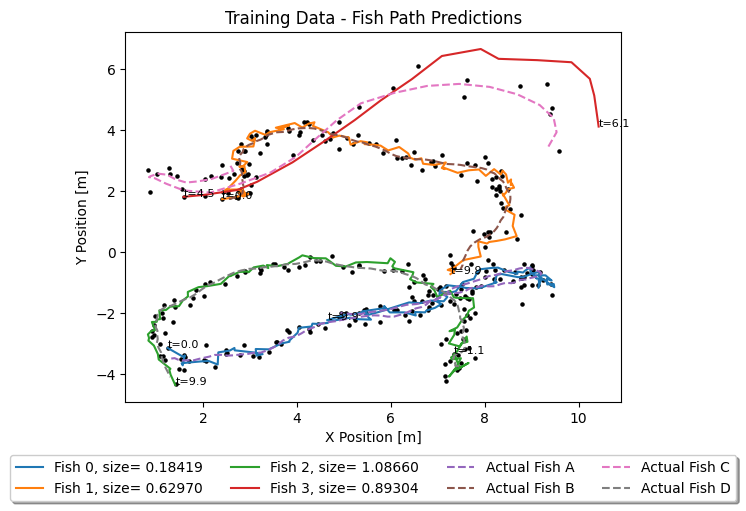

In [14]:
# Try with training Data Set
tracker = MultiTracker(noises=[pos_noise, vel_noise, acc_noise, size_noise])
 
# Pipe Data Through the multi-tracker
for index, row in training_data.iterrows():
    time = row['Time']
    measurements = []
    for i in range(4):
        if not np.isnan(row[f'dist_{i}']):
            measurements.append((row[f'dist_{i}'], row[f'angle_{i}'], row[f'size_{i}']))
    tracker.update(time, measurements)
    
# Get the list of predicted tracks
ids, predictions = tracker.get_predictions()

all_measurements = pd.DataFrame({
    'Time': training_data['Time'],
    'dist_0': training_data['dist_0'],
    'angle_0': training_data['angle_0'],
    'dist_1': training_data['dist_1'],
    'angle_1': training_data['angle_1'],
    'dist_2': training_data['dist_2'],
    'angle_2': training_data['angle_2'],
    'dist_3': training_data['dist_3'],
    'angle_3': training_data['angle_3'],
})
all_measurements = all_measurements.assign(
    x_0 = all_measurements["dist_0"] * np.cos(np.deg2rad(all_measurements["angle_0"])),
    y_0 = all_measurements["dist_0"] * np.sin(np.deg2rad(all_measurements["angle_0"])),
    x_1 = all_measurements["dist_1"] * np.cos(np.deg2rad(all_measurements["angle_1"])),
    y_1 = all_measurements["dist_1"] * np.sin(np.deg2rad(all_measurements["angle_1"])),
    x_2 = all_measurements["dist_2"] * np.cos(np.deg2rad(all_measurements["angle_2"])),
    y_2 = all_measurements["dist_2"] * np.sin(np.deg2rad(all_measurements["angle_2"])),
    x_3 = all_measurements["dist_3"] * np.cos(np.deg2rad(all_measurements["angle_3"])),
    y_3 = all_measurements["dist_3"] * np.sin(np.deg2rad(all_measurements["angle_3"])),
)

# Plot the tracks together on 1 graph
plt.figure()
for i, id in enumerate(ids):
    size = np.mean([s for s in predictions[f's_{id}'] if not np.isnan(s)])
    plt.plot(predictions[f'x_{id}'], predictions[f'y_{id}'], label=f'Fish {i}, size={size: 0.5f}')
    # Annotate the start and end of each movement with the time
    state = False
    for j, vals in predictions.iterrows():
        if ((not state and not np.isnan(vals[f'x_{id}'])) or j == len(predictions)-1):
            state = True
            plt.annotate(f't={vals['Time']}', (vals[f'x_{id}'], vals[f'y_{id}']), size=8)
        elif (state and np.isnan(vals[f'x_{id}'])):
            state = False
            vals = predictions.loc[j-1]
            plt.annotate(f't={vals['Time']}', (vals[f'x_{id}'], vals[f'y_{id}']), size=8)
for i in range(4):
    label=f'Actual Fish {['A','B','C','D'][i]}'
    plt.plot(training_labels[f'x_{i}'], training_labels[f'y_{i}'], label=label, linestyle='--')
for i in range(4):
    plt.scatter(all_measurements['x_'+str(i)], all_measurements['y_'+str(i)], s=5, color='black')
plt.title('Training Data - Fish Path Predictions')
plt.xlabel('X Position [m]')
plt.ylabel('Y Position [m]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),
           fancybox=True, shadow=True, ncol=4)
plt.savefig('out/p1_training_paths.png', bbox_inches='tight')
plt.show()

## Run on Test Data and Plot Results

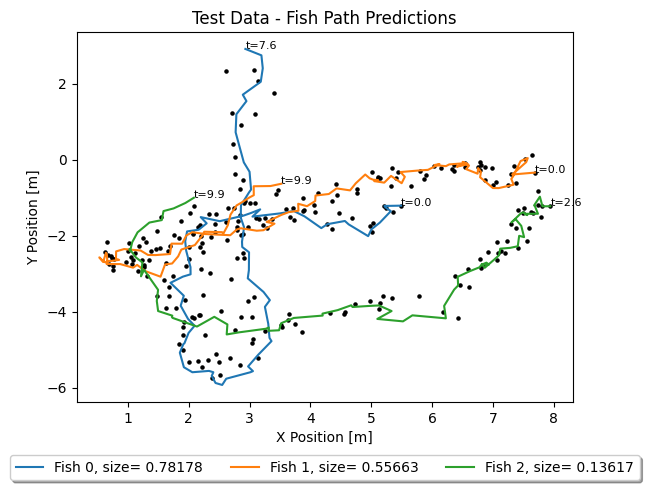

+--------+---------+------------+----------+-------------+-------------+------------------------------------------------------+
| Fish # |   Size  | Time Start | Time End | Final X [m] | Final Y [m] |                      Final Cov.                      |
+--------+---------+------------+----------+-------------+-------------+------------------------------------------------------+
| Fish 0 | +0.7818 |  +0.0000   | +7.6000  |   +2.9305   |   +2.9110   | [[+0.029 +0.007 +0.048 +0.009 +0.006 +0.001 +0.000]  |
|        |         |            |          |             |             |  [+0.007 +0.026 +0.009 +0.044 +0.001 +0.006 +0.000]  |
|        |         |            |          |             |             |  [+0.048 +0.009 +0.257 +0.013 +0.032 +0.002 +0.000]  |
|        |         |            |          |             |             |  [+0.009 +0.044 +0.013 +0.248 +0.002 +0.031 +0.000]  |
|        |         |            |          |             |             |  [+0.006 +0.001 +0.032 +0.002 +

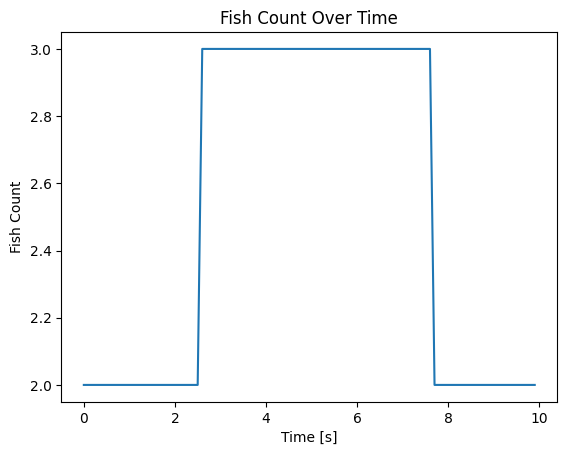

In [15]:
# Filter the Test Data
test_tracker = MultiTracker(noises=[pos_noise, vel_noise, acc_noise, size_noise])
for index, row in test_data.iterrows():
    time = row['Time']
    measurements = []
    for i in range(3):
        if not np.isnan(row[f'dist_{i}']):
            measurements.append((row[f'dist_{i}'], row[f'angle_{i}'], row[f'size_{i}']))
    test_tracker.update(time, measurements)
    
# Get the list of predicted tracks
ids, predictions = test_tracker.get_predictions()

# Plot the tracks together on 1 graph
plt.figure()
for i, id in enumerate(ids):
    size = np.mean([s for s in predictions[f's_{id}'] if not np.isnan(s)])
    plt.plot(predictions[f'x_{id}'], predictions[f'y_{id}'], label=f'Fish {i}, size={size: 0.5f}')
    # Annotate the start and end of each movement with the time
    state = False
    for j, vals in predictions.iterrows():
        if ((not state and not np.isnan(vals[f'x_{id}'])) or j == len(predictions)-1):
            state = True
            plt.annotate(f't={vals['Time']}', (vals[f'x_{id}'], vals[f'y_{id}']), size=8)
        elif (state and np.isnan(vals[f'x_{id}'])):
            state = False
            vals = predictions.loc[j-1]
            plt.annotate(f't={vals['Time']}', (vals[f'x_{id}'], vals[f'y_{id}']), size=8)
# Add scatter of all measurements to the plot
for i in range(3):
    plt.scatter(test_data['dist_'+str(i)] * np.cos(np.deg2rad(test_data['angle_'+str(i)])),
                test_data['dist_'+str(i)] * np.sin(np.deg2rad(test_data['angle_'+str(i)])),
                s=5, color='black')
plt.title('Test Data - Fish Path Predictions')
plt.xlabel('X Position [m]')
plt.ylabel('Y Position [m]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),
           fancybox=True, shadow=True, ncol=3)
plt.savefig('out/p1_test_paths.png', bbox_inches='tight')
plt.show()

# Print the final Position and covariance of each Fish
table = [['Fish #', 'Size', 'Time Start', 'Time End', 'Final X [m]', 'Final Y [m]', 'Final Cov.']]
for i, id in enumerate(ids):
    size = np.mean([s for s in predictions[f's_{id}'] if not np.isnan(s)])
    start_time = 0
    end_time = 0
    final_x = 0
    final_y = 0
    final_cov = 0
    state = False
    for j, vals in predictions.iterrows():
        if ((not state and not np.isnan(vals[f'x_{id}']))):
            state = True
            start_time = vals['Time']
        elif (j == len(predictions)-1):
            end_time = vals['Time']
            final_x = vals[f'x_{id}']
            final_y = vals[f'y_{id}']
            final_cov = vals[f'cov_{id}']
            break
        elif (state and np.isnan(vals[f'x_{id}'])):
            state = False
            vals = predictions.loc[j-1]
            end_time = vals['Time']
            final_x = vals[f'x_{id}']
            final_y = vals[f'y_{id}']
            final_cov = vals[f'cov_{id}']
            break
    table.append([f'Fish {i}',
                  f'{size:+0.4f}',
                  f'{start_time:+0.4f}',
                  f'{end_time:+0.4f}',
                  f'{final_x:+0.4f}',
                  f'{final_y:+0.4f}',
                  final_cov])
tab = PrettyTable(table[0])
tab.add_rows(table[1:])
with np.printoptions(formatter={'float': lambda x: "{0:+0.3f}".format(x)}):
    print(tab)

# Create an index of the number of fish at each timestamp
fish_count_list = []
for i, vals in predictions.iterrows():
    sum = 0
    for j, id in enumerate(ids):
        sum += not np.isnan(vals[f'x_{id}'])
    fish_count_list.append(sum)
# Write to a CSV file
with open('out/test_data_fish_count.csv', 'w', newline='') as csvfile:
    write = csv.writer(csvfile, delimiter=',')
    for count in fish_count_list:
        write.writerow([count])
# Plot the fish at times
plt.figure()
plt.plot(predictions['Time'], fish_count_list)
plt.title('Fish Count Over Time')
plt.xlabel('Time [s]')
plt.ylabel('Fish Count')
plt.savefig('out/p1_fish_count.png')
plt.show()